# Dataload & Imports

In [145]:
import pandas as pd
import plotly.graph_objects as go
from plotly_resampler import FigureResampler, FigureWidgetResampler
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import os
from sysidentpy.metrics import root_relative_squared_error

In [146]:
dirname = os.getcwd()
filename = dirname + "/data/pump_station_data.parquet"
print(filename)

/home/s193881/Industrial-IoT-For-Digitization-Of-Electronic-Assets-Course/Final Project/data/pump_station_data.parquet


In [147]:
pump_station_data = pd.read_parquet(filename)
pump_station_data.head(5)
pump_station_data = pump_station_data[(pump_station_data["pump1_rpm"] > 0) & (pump_station_data["pump4_rpm"] == 0)]
train = pump_station_data.loc["2023-01-27":"2023-01-30"]
test = pump_station_data.loc["2023-02-27":"2023-03-02"] 

In [6]:
#import numpy as np
#pump_station_data.loc["2023-01-27 00:00:00.000000+00:00"]
#pump_station_data_subset = pump_station_data.iloc[946899:946899+86400]
#pump_station_data_subset2 = pump_station_data.iloc[946899+86400:946899+2*86400]
#n=0.5

#x_train, x_test = train_test_split(pump_station_data_subset, test_size=n)
#y_train, y_test = train_test_split(pump_station_data_subset2, test_size=n)


# Static Model


## Hvad vil vi modellere?
* Outflow over rpm
    * Pump1
    * Pump2
* Power over rpm
* Power over outflow

### Outflow as a function of pump speed.

In [148]:
x_train = train["pump1_rpm"].values.reshape(-1,1)
y_train = train["outflow"].values.reshape(-1,1)
x_test = test["pump1_rpm"].values.reshape(-1,1)
y_test = test["outflow"].values.reshape(-1,1)

mask = y_test >= 0.9*x_test-680
filtered_x = x_test[mask]
filtered_y = y_test[mask]

coefficients,residuals,_,_,_ = np.polyfit(filtered_x, filtered_y, 1, full=True)

fit_curve = np.poly1d(coefficients)
x_series = np.arange(0, 1400, 1)
y_fit = coefficients[0]*x_series+coefficients[1]

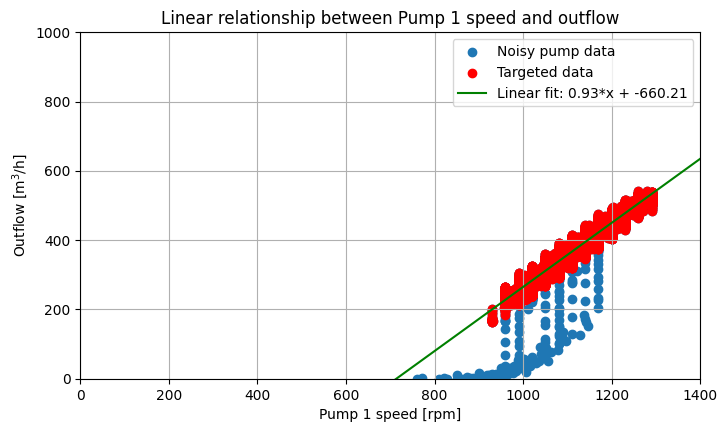

In [149]:
plt.figure(1,figsize=(8,4.5))
plt.scatter(y=y_test, x=x_test, label="Noisy pump data")
plt.scatter(y=filtered_y, x=filtered_x, color="red", label=f'Targeted data')
plt.plot(y_fit, color="g", label=f'Linear fit: {coefficients[0]:.2f}*x + {coefficients[1]:.2f}')
plt.legend()
plt.xlim(0, 1400)
plt.ylim(0, 1000)
plt.ylabel("Outflow [m$^3$/h]")
plt.xlabel("Pump 1 speed [rpm]")
plt.title("Linear relationship between Pump 1 speed and outflow")
plt.grid(True)

In [152]:
def print_errors(filtered_y, filtered_x, coefficients, residuals, deg):
    print("MSE: " + str(residuals/len(mask))) #Mean Squared Error
    print("RMSE: " + str(np.sqrt(residuals/len(mask)))) #Root Mean Squared Error

    if(deg == 1):
        absolute_errors = np.zeros(len(filtered_y))
        for i in range(len(filtered_y)):
            absolute_errors[i] = np.absolute((coefficients[0]*filtered_x[i] + coefficients[1]) - filtered_y[i])

        print("MAE: " + str(np.mean(absolute_errors))) #Mean Absolute Error

        fit_values = np.zeros(len(filtered_x))

        for i in range(len(filtered_x)):
            fit_values[i] = coefficients[0]*filtered_x[i] + coefficients[1]

        print("RRSE: " + str(root_relative_squared_error(filtered_y, fit_values))) #Root Relative Squared Error
    elif(deg==2):
        absolute_errors = np.zeros(len(filtered_y))
        for i in range(len(filtered_y)):
            absolute_errors[i] = np.absolute((coefficients[0]*filtered_x[i]**2 + coefficients[1]*filtered_x[i] + coefficients[2]) - filtered_y[i])

        print("MAE: " + str(np.mean(absolute_errors))) #Mean Absolute Error

        fit_values = np.zeros(len(filtered_x))

        for i in range(len(filtered_x)):
            fit_values[i] = coefficients[0]*(filtered_x[i]**2) + coefficients[1]*filtered_x[i] + coefficients[2]

        print("RRSE: " + str(root_relative_squared_error(filtered_y, fit_values))) #Root Relative Squared Error

print_errors(filtered_y, filtered_x, coefficients, residuals, 1)


MSE: [128.57533979]
RMSE: [11.33910666]


MAE: 8.596453645225662
RRSE: 0.1903138691513625


In [183]:
pump_station_data = pd.read_parquet(filename)
pump_station_data = pump_station_data[(pump_station_data["pump1_rpm"] == 0) & (pump_station_data["pump4_rpm"] > 0)]
train = pump_station_data.loc["2023-01-27":"2023-01-30"]
test = pump_station_data.loc["2023-02-27":"2023-03-02"] 
x_train = train["pump4_rpm"].values.reshape(-1,1)
y_train = train["outflow"].values.reshape(-1,1)
x_test = test["pump4_rpm"].values.reshape(-1,1)
y_test = test["outflow"].values.reshape(-1,1)


In [193]:

mask = y_test >= 1.17*x_test-800
filtered_x_temp = x_test[mask]
filtered_y_temp = y_test[mask]
filtered_x_temp = filtered_x_temp.reshape(-1,1)
filtered_y_temp = filtered_y_temp.reshape(-1,1)

mask =  filtered_x_temp >=700

filtered_x = filtered_x_temp[mask]
filtered_y = filtered_y_temp[mask]

coefficients,residuals,_,_,_ = np.polyfit(filtered_x, filtered_y, 1, full=True)

fit_curve = np.poly1d(coefficients)
x_series = np.arange(0, 1400, 1)
y_fit = coefficients[0]*x_series+coefficients[1]

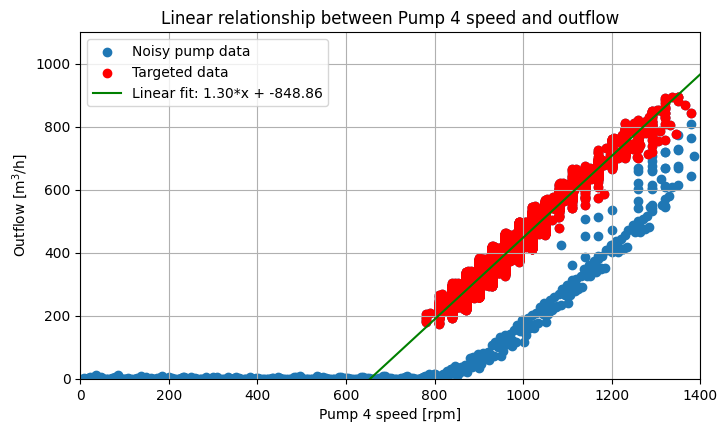

In [194]:
plt.figure(1,figsize=(8,4.5))
plt.scatter(y=y_test, x=x_test, label="Noisy pump data")
plt.scatter(y=filtered_y, x=filtered_x, color="red", label=f'Targeted data')
plt.plot(y_fit, color="g", label=f'Linear fit: {coefficients[0]:.2f}*x + {coefficients[1]:.2f}')
plt.legend()
plt.xlim(0, 1400)
plt.ylim(0, 1100)
plt.ylabel("Outflow [m$^3$/h]")
plt.xlabel("Pump 4 speed [rpm]")
plt.title("Linear relationship between Pump 4 speed and outflow")
plt.grid(True)

In [156]:
print_errors(filtered_y, filtered_x, coefficients, residuals, 1)

MSE: [260.88781706]
RMSE: [16.15202207]
MAE: 11.90056596009969
RRSE: 0.2329848541096947


### Power as a function of pump speed.

In [157]:
pump_station_data = pd.read_parquet(filename)
pump_station_data = pump_station_data[(pump_station_data["pump1_rpm"] == 0) & (pump_station_data["pump4_rpm"] > 0)]
train = pump_station_data.loc["2023-01-27":"2023-01-30"]
test = pump_station_data.loc["2023-02-27":"2023-03-02"] 
x_train = train["pump4_rpm"].values.reshape(-1,1)
y_train = train["pump4_power"].values.reshape(-1,1)
x_test = test["pump4_rpm"].values
y_test = test["pump4_power"].values

In [159]:
mask = x_test >= 300
filtered_x = x_test[mask]
filtered_y = y_test[mask]

coefficients,residuals,_,_,_ = np.polyfit(filtered_x, filtered_y, 2, full=True)#deg=1 for linear fit, deg=2 for quadratic


fit_curve = np.poly1d(coefficients)
x_series = np.arange(0, 1400, 1)
#y_fit = coefficients[0]*x_series+coefficients[1] #Linear fit
y_fit = coefficients[0]*x_series**2+coefficients[1]*x_series+coefficients[2] #Quadratic fit

print(coefficients)

[ 5.82407509e-05 -3.98402796e-02  2.57416318e+01]


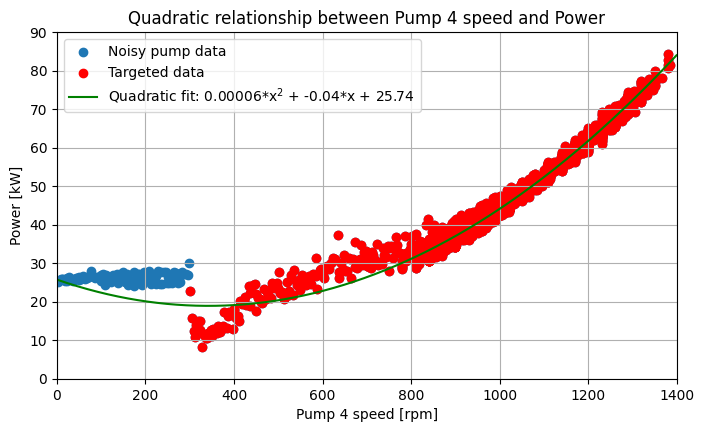

In [160]:

plt.figure(1,figsize=(8,4.5))
plt.scatter(y=y_test, x=x_test, label="Noisy pump data")
plt.scatter(y=filtered_y, x=filtered_x, color="red", label=f'Targeted data')
#plt.plot(y_fit, color="g", label=f'Linear fit: {coefficients[0]:.2f}*x + {coefficients[1]:.2f}') #Linear fit
plt.plot(y_fit, color="g", label=f'Quadratic fit: {coefficients[0]:.5f}*x$^2$ + {coefficients[1]:.2f}*x + {coefficients[2]:.2f}')#quadratic fit
plt.legend()
plt.xlim(0, 1400)
plt.ylim(0, 90)
plt.ylabel("Power [kW]")
plt.xlabel("Pump 4 speed [rpm]")
plt.title("Quadratic relationship between Pump 4 speed and Power")
plt.grid(True)

In [161]:
print_errors(filtered_y, filtered_x, coefficients, residuals, 2)

MSE: [0.82496875]
RMSE: [0.90827791]
MAE: 0.7166200122136328
RRSE: 0.22846444213629466


In [162]:
pump_station_data = pd.read_parquet(filename)
pump_station_data = pump_station_data[(pump_station_data["pump1_rpm"] > 0) & (pump_station_data["pump4_rpm"] == 0)]
train = pump_station_data.loc["2023-01-27":"2023-01-30"]
test = pump_station_data.loc["2023-02-27":"2023-03-02"] 
x_train = train["pump1_rpm"].values.reshape(-1,1)
y_train = train["pump1_power"].values.reshape(-1,1)
x_test = test["pump1_rpm"].values
y_test = test["pump1_power"].values

In [163]:
mask = x_test >= 900
filtered_x = x_test[mask]
filtered_y = y_test[mask]

coefficients,residuals,_,_,_ = np.polyfit(filtered_x, filtered_y, 1, full=True)

fit_curve = np.poly1d(coefficients)
x_series = np.arange(0, 1400, 1)
y_fit = coefficients[0]*x_series+coefficients[1]

print(coefficients)

[  0.06759796 -29.50064281]


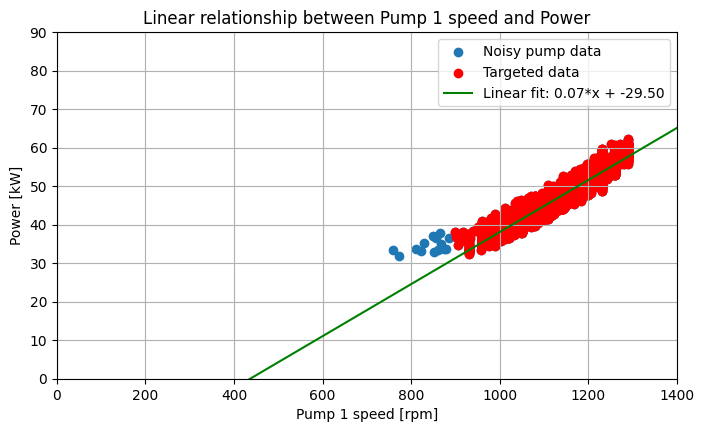

In [164]:
plt.figure(1,figsize=(8,4.5))
plt.scatter(y=y_test, x=x_test, label="Noisy pump data")
plt.scatter(y=filtered_y, x=filtered_x, color="red", label=f'Targeted data')
plt.plot(y_fit, color="g", label=f'Linear fit: {coefficients[0]:.2f}*x + {coefficients[1]:.2f}')
plt.legend()
plt.xlim(0, 1400)
plt.ylim(0, 90)
plt.ylabel("Power [kW]")
plt.xlabel("Pump 1 speed [rpm]")
plt.title("Linear relationship between Pump 1 speed and Power")
plt.grid(True)

In [165]:
print_errors(filtered_y, filtered_x, coefficients, residuals, 1)

MSE: [1.38048397]
RMSE: [1.17493998]
MAE: 0.9492805123612307
RRSE: 0.26468053381611495


### Outflow vs. Power

In [175]:
pump_station_data = pd.read_parquet(filename)
pump_station_data = pump_station_data[(pump_station_data["pump1_rpm"] == 0) & (pump_station_data["pump4_rpm"] > 0)]
train = pump_station_data.loc["2023-01-27":"2023-01-30"]
test = pump_station_data.loc["2023-02-27":"2023-03-02"] 
x_train = train["pump4_power"].values.reshape(-1,1)
y_train = train["outflow"].values.reshape(-1,1)
x_test = test["pump4_power"].values
y_test = test["outflow"].values

In [176]:
mask = y_test >= 16.2*x_test-400
filtered_x_temp = x_test[mask]
filtered_y_temp = y_test[mask]
filtered_x_temp = filtered_x_temp.reshape(-1,1)
filtered_y_temp = filtered_y_temp.reshape(-1,1)

mask =  filtered_x_temp >=25

filtered_x = filtered_x_temp[mask]
filtered_y = filtered_y_temp[mask]

coefficients, residuals,_,_,_ = np.polyfit(filtered_x, filtered_y, 1, full=True)

fit_curve = np.poly1d(coefficients)
x_series = np.arange(0, 90, 1)
y_fit = coefficients[0]*x_series+coefficients[1]

print(coefficients)

[  16.94612358 -305.55694258]


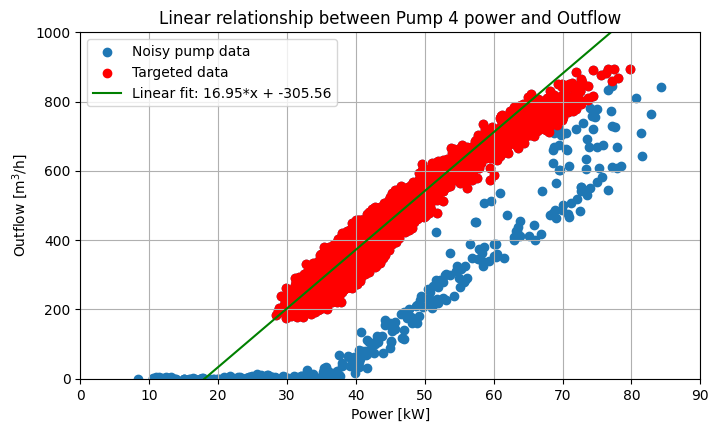

In [177]:
plt.figure(1,figsize=(8,4.5))
plt.scatter(y=y_test, x=x_test, label="Noisy pump data")
plt.scatter(y=filtered_y, x=filtered_x, color="red", label=f'Targeted data')
plt.plot(y_fit, color="g", label=f'Linear fit: {coefficients[0]:.2f}*x + {coefficients[1]:.2f}')
plt.legend()
plt.xlim(0, 90)
plt.ylim(0, 1000)
plt.ylabel("Outflow [m$^3$/h]")
plt.xlabel("Power [kW]")
plt.title("Linear relationship between Pump 4 power and Outflow")
plt.grid(True)

In [170]:
print_errors(filtered_y, filtered_x, coefficients, residuals, 1)

MSE: [546.53982214]
RMSE: [23.37819116]
MAE: 18.439287542525495
RRSE: 0.33750401361549437


In [178]:
pump_station_data = pd.read_parquet(filename)
pump_station_data = pump_station_data[(pump_station_data["pump1_rpm"] > 0) & (pump_station_data["pump4_rpm"] == 0)]
train = pump_station_data.loc["2023-01-27":"2023-01-30"]
test = pump_station_data.loc["2023-02-27":"2023-03-02"] 
x_train = train["pump1_power"].values.reshape(-1,1)
y_train = train["outflow"].values.reshape(-1,1)
x_test = test["pump1_power"].values
y_test = test["outflow"].values

In [179]:
mask = y_test >= 14*x_test-390
filtered_x = x_test[mask]
filtered_y = y_test[mask]

coefficients, residuals,_,_,_ = np.polyfit(filtered_x, filtered_y, 1, full=True)

fit_curve = np.poly1d(coefficients)
x_series = np.arange(0, 90, 1)
y_fit = coefficients[0]*x_series+coefficients[1]

print(coefficients)

[  12.72386794 -212.14559054]


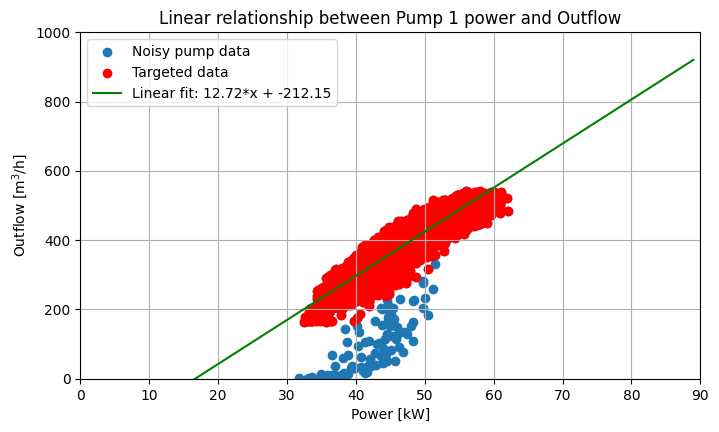

In [180]:
plt.figure(1,figsize=(8,4.5))
plt.scatter(y=y_test, x=x_test, label="Noisy pump data")
plt.scatter(y=filtered_y, x=filtered_x, color="red", label=f'Targeted data')
plt.plot(y_fit, color="g", label=f'Linear fit: {coefficients[0]:.2f}*x + {coefficients[1]:.2f}')
plt.legend()
plt.xlim(0, 90)
plt.ylim(0, 1000)
plt.ylabel("Outflow [m$^3$/h]")
plt.xlabel("Power [kW]")
plt.title("Linear relationship between Pump 1 power and Outflow")
plt.grid(True)

# Dynamic Model

In [5]:
pump_station_data = pd.read_parquet(filename)
pump_station_data.head(5)

train = pump_station_data.loc["2023-01-27":"2023-01-30"]
test = pump_station_data.loc["2023-02-27":"2023-03-02"] 

#Consider resample()
pump_station_data = pump_station_data.resample("1T").mean()

pump_station_data = pump_station_data[(pump_station_data["pump1_rpm"] > 0) & (pump_station_data["pump4_rpm"] == 0)]
x_train = train["pump1_rpm"].values.reshape(-1,1)
y_train = train["outflow"].values.reshape(-1,1)
x_test = test["pump1_rpm"].values.reshape(-1,1)
y_test = test["outflow"].values.reshape(-1,1)

In [11]:
import pandas as pd 
from sysidentpy.model_structure_selection import FROLS 
from sysidentpy.basis_function._basis_function import Polynomial 
from sysidentpy.metrics import root_relative_squared_error 
from sysidentpy.utils.display_results import results
import plotly.graph_objects as go
from plotly_resampler import FigureResampler, FigureWidgetResampler
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np



basis_function = Polynomial(degree=1)

model = FROLS(
    order_selection=True,
    n_info_values=5,
    extended_least_squares=False,
    ylag=2,
    xlag=2,
    info_criteria="aic",
    estimator="least_squares",
    basis_function=basis_function,
)
model.fit(X=x_train, 
          y=y_train)




/home/smrobot/miniconda3/envs/module3_env/lib/python3.11/site-packages/sysidentpy/utils/deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


In [14]:
yhat = model.predict(X=x_test, 
                     y=y_test,
                     forecast_horizon=200)

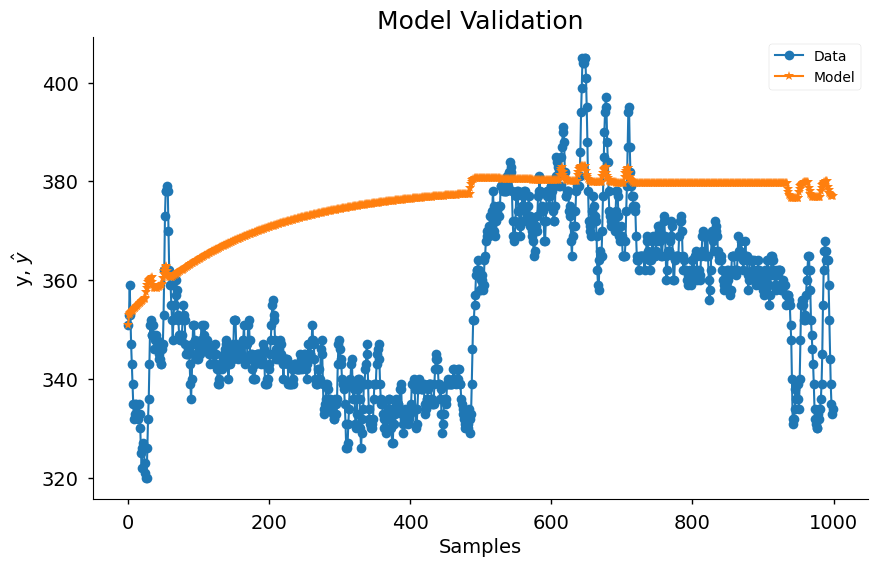

In [15]:
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results

plot_results(y=y_test, yhat=yhat, n=1000, title="Model Validation",
    style='seaborn-v0_8-notebook',
    facecolor="white")

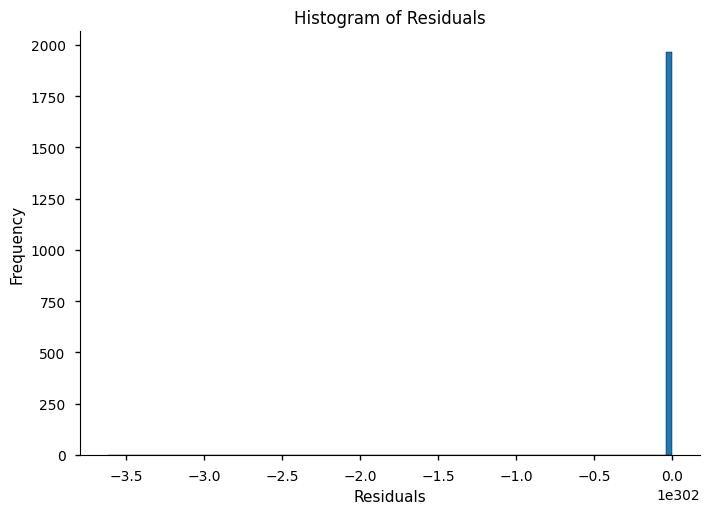

In [15]:
residuals = y_test - yhat

# Plotting the histogram of residuals
plt.hist(residuals, bins=100, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
#plt.xlim(-50,50)
plt.show()

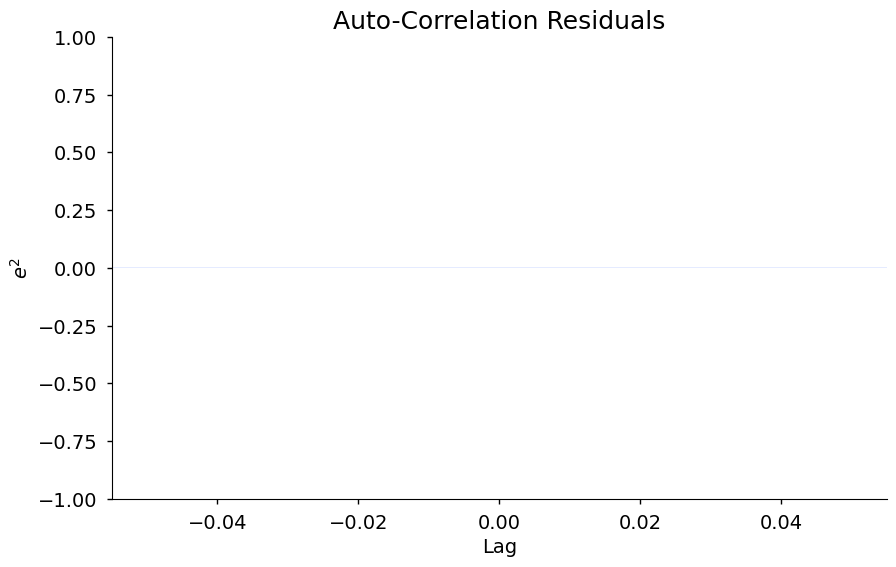

In [16]:
from sysidentpy.utils.plotting import plot_residues_correlation
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

ee = compute_residues_autocorrelation(y_test, yhat)
plot_residues_correlation(data=ee, title="Auto-Correlation Residuals", ylabel="$e^2$", style='seaborn-v0_8-notebook')

In [ ]:
from sysidentpy.residues.residues_correlation import compute_cross_correlation

#x1e = compute_cross_correlation(y_test, yhat, x_test)
#plot_residues_correlation(data=x1e, title="Cross-Correlation Residuals", ylabel="$x_1e$", style='seaborn-v0_8-notebook')

# NEURAL NETWORK


In [7]:
import numpy as np
import pandas as pd

from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.neural_network import NARXNN

from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)
from sysidentpy.utils.narmax_tools import regressor_code
import torch
from torch import nn
from sysidentpy.utils.display_results import results
from plotly_resampler import FigureResampler, FigureWidgetResampler


In [8]:
from sklearn.preprocessing import StandardScaler

pump_station_data = pd.read_parquet("/home/s193864/Industrial-IoT-For-Digitization-Of-Electronic-Assets-Course/Final Project/data/pump_station_data.parquet")
pump_station_data.head(5)


,height,outflow,pump1_rpm,pump1_power,pump4_rpm,pump4_power
time,,,,,,
2023-01-16 00:00:00.970000+00:00,167.0,533.0,1260.0,57.54,0.0,0.0
2023-01-16 00:00:01.969000+00:00,167.0,534.0,1260.0,55.40,0.0,0.0
2023-01-16 00:00:02.969000+00:00,167.0,527.0,1260.0,58.09,0.0,0.0
2023-01-16 00:00:03.969000+00:00,167.0,521.0,1260.0,58.71,0.0,0.0
2023-01-16 00:00:04.969000+00:00,167.0,521.0,1260.0,54.62,0.0,0.0


In [9]:
pump_station_data = pump_station_data.resample("1T").mean()

In [10]:

pump_station_data = pump_station_data[(pump_station_data["pump1_rpm"] > 0) & (pump_station_data["pump4_rpm"] == 0)]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(pump_station_data)
df_scaled = pd.DataFrame(scaled_data, columns=pump_station_data.columns, index=pump_station_data.index)

train = df_scaled.loc["2023-01-27":"2023-01-30"]
test = df_scaled.loc["2023-02-27":"2023-03-02"] 

#FEATURES = ['height', 'outflow']
FEATURES = "pump1_rpm"
TARGET = 'outflow'

x_train, y_train = train[FEATURES].values.reshape(-1,1), train[TARGET].values.reshape(-1,1)
x_test, y_test= test[FEATURES].values.reshape(-1,1), test[TARGET].values.reshape(-1,1)



In [11]:
fig = FigureWidgetResampler(go.Figure())
fig.update_layout(margin=dict(l=10, r=10, t=10, b=10))
fig.add_trace(go.Scattergl(name=r'Height', showlegend=True), hf_x=df_scaled.index, hf_y=df_scaled['height'])
fig.add_trace(go.Scattergl(name=r'Outflow', showlegend=True), hf_x=df_scaled.index, hf_y=df_scaled['outflow'])
fig.add_trace(go.Scattergl(name=r'pump1_rpm', showlegend=True), hf_x=df_scaled.index, hf_y=df_scaled['pump1_rpm'])
fig.add_trace(go.Scattergl(name=r'pump1_power', showlegend=True), hf_x=df_scaled.index, hf_y=df_scaled['pump1_power'])
fig.add_trace(go.Scattergl(name=r'pump4_rpm', showlegend=True), hf_x=df_scaled.index, hf_y=df_scaled['pump4_rpm'])
fig.add_trace(go.Scattergl(name=r'pump4_power', showlegend=True), hf_x=df_scaled.index, hf_y=df_scaled['pump4_power'])
fig.update_layout(height=400, template="plotly_dark")
display(fig)

NameError: name 'go' is not defined

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [13]:
basis_function = Polynomial(degree=1)

narx_net = NARXNN(
    ylag=2,
    xlag=2,
    basis_function=basis_function,
    model_type="NARMAX",
    loss_func="mse_loss",
    optimizer="Adam",
    #optimizer="sgd",
    epochs=10,
    learning_rate = 4e-3,
    verbose=False,
    optim_params={
        "betas": (0.9, 0.999),
        "eps": 1e-05,
    }, 
)

### Building the network

In [14]:
class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(4, 50)
        self.lin2 = nn.Linear(50, 50)
        self.lin3 = nn.Linear(50, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

### Passing the defined network to our NARXNN estimator

In [15]:
narx_net.net = NARX()
if device == "cuda": narx_net.net.to(torch.device("cuda"))

### Fit & Predict

In [16]:
narx_net.fit(X=x_train, y=y_train.reshape(-1,1))
#narx_net.fit(X=x_train.reshape(-1,1), y=y_train.reshape(-1,1), X_test=x_test.reshape(-1,1), y_test=y_test.reshape(-1,1))

In [17]:
#yhat = narx_net.predict(X=x_test.reshape(-1,1), y=y_test.reshape(-1,1))
yhat = narx_net.predict(X=x_test, y=y_test.reshape(-1,1))
print("MSE: ", mean_squared_error(y_test, yhat))

MSE:  0.06474318918200801


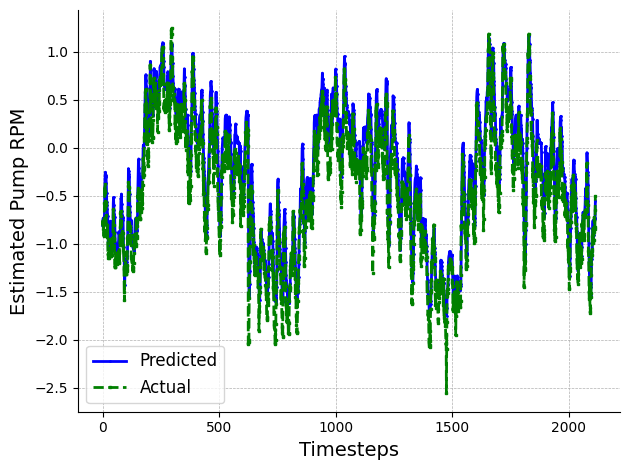

In [18]:
import matplotlib.pyplot as plt 
plt.plot(yhat, color='blue', linestyle='-', linewidth=2, marker='o', markersize=1, label='Predicted')
plt.plot(y_test, color='green', linestyle='--', linewidth=2, marker='s', markersize=1.5, label='Actual')
plt.xlabel('Timesteps', fontsize=14)
plt.ylabel('Estimated Pump RPM', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adding a legend
plt.legend(fontsize=12)

# Adjusting the margins and layout
plt.tight_layout()

# Show the plot
plt.show()

MSE:  0.06474318918200801


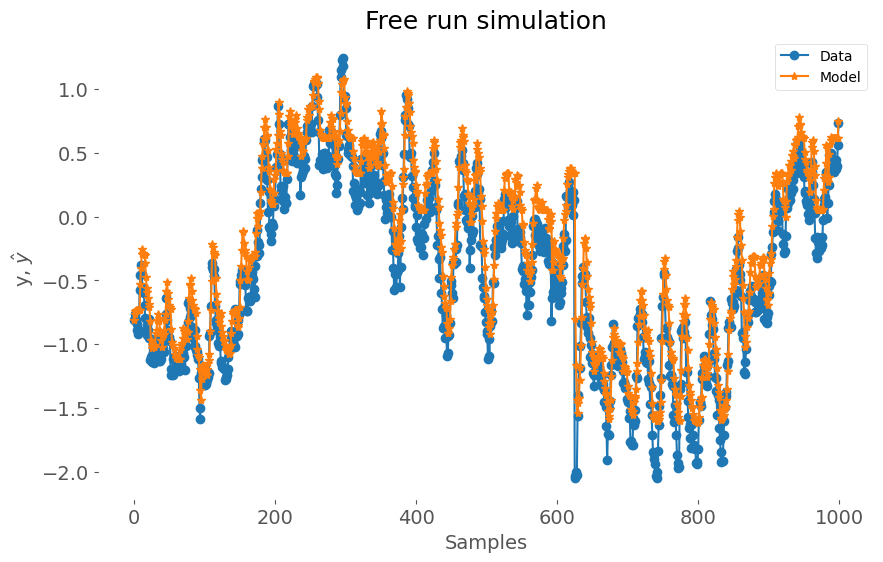

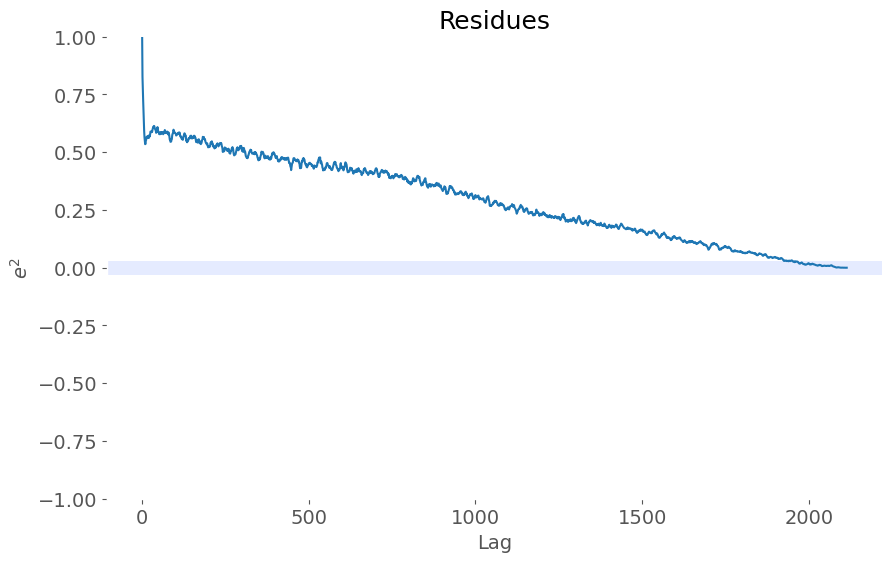

In [19]:
print("MSE: ", mean_squared_error(y_test.reshape(-1,1), yhat.reshape(-1,1)))
plot_results(y=y_test.reshape(-1,1), yhat=yhat.reshape(-1,1), n=1000, style='ggplot')
ee = compute_residues_autocorrelation(y_test.reshape(-1,1), yhat.reshape(-1,1))
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$", style='ggplot')
#x1e = compute_cross_correlation(y_test.reshape(-1,1), yhat.reshape(-1,1), x_test.reshape(-1,1))
#plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$", style='ggplot')

# HERFRA ANER JEG IKKE HVAD DER FOREGÅR

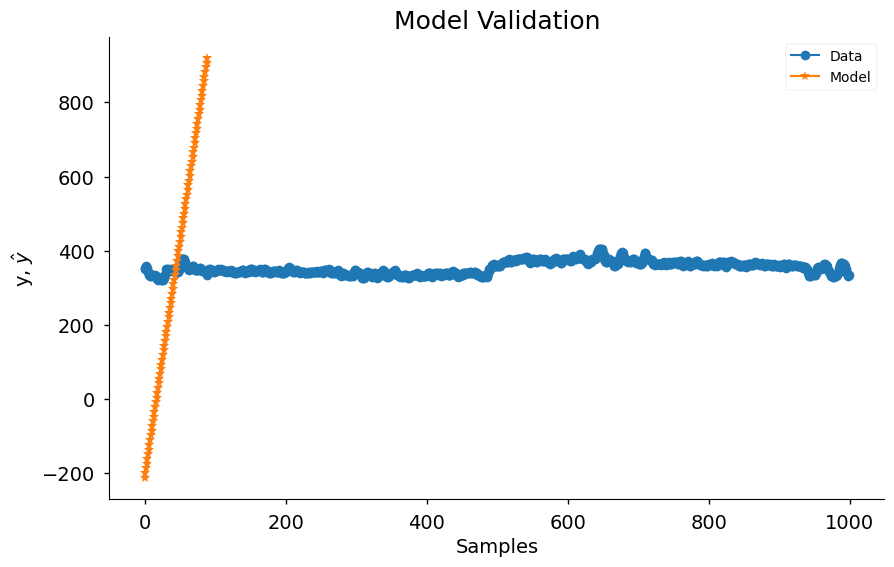

In [ ]:
plot_results(y=y_test, yhat=y_fit, n=1000, title="Model Validation",
    style='seaborn-v0_8-notebook',
    facecolor="white")

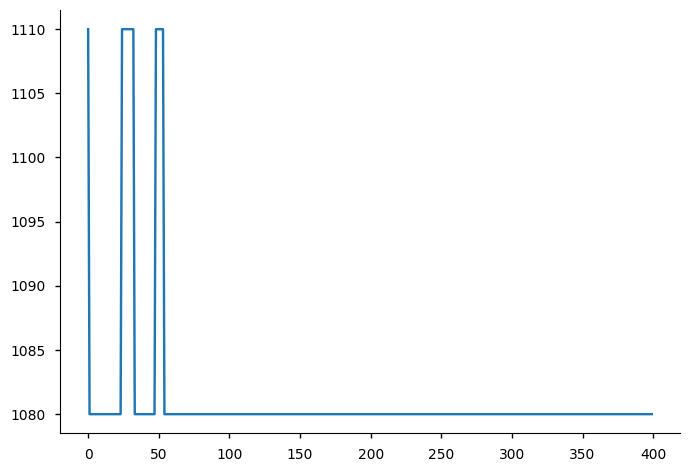

In [ ]:
plt.plot(x_test.squeeze()[:400])

In [ ]:


rrse = root_relative_squared_error(y_test, 
                                   yhat)
print(rrse)

r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

0.2491088852320484
  Regressors   Parameters             ERR
0     y(k-1)   1.1736E+00  9.99824800E-01
1     y(k-2)  -2.9681E-01  1.10400394E-05
2    x1(k-2)   1.8670E-01  1.21761055E-06
3          1  -8.1871E+01  1.72776050E-05
4    x1(k-1)  -7.1214E-02  7.82510728E-07


# Plots & Stuff

In [21]:
fig = FigureWidgetResampler(go.Figure())
fig.add_trace(go.Scattergl(name='Pump 1 [rpm]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump1_rpm"])
fig.add_trace(go.Scattergl(name='Pump 4 [rpm]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump4_rpm"])
#fig.add_trace(go.Scattergl(name='Pump 1 [kW]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump1_power"])
#fig.add_trace(go.Scattergl(name='Pump 1 [kW]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump4_power"])
#fig.add_trace(go.Scattergl(name='Height', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["height"])
#fig.add_trace(go.Scattergl(name='Outflow', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["outflow"])

fig

fig.update_layout(
    autosize=False,
    width=1200,
    height=750,
    font_family="TimesNewRoman",
    legend=dict(
        title=None, orientation="h", y=-0.40, yanchor="bottom", x=0.5 , xanchor="center", font_color="white"
    ),
    plot_bgcolor='#333',
    paper_bgcolor="#333",
    title="This is graph",
    title_font_color="white",
    title_font_size=30
)

fig.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='gray',
    gridcolor='gray',
    color="white"
)
fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='gray',
    gridcolor='gray',
    color="white",
    ticksuffix="[rpm]", showgrid=True
)

FigureWidgetResampler({
    'data': [{'name': ('<b style="color:sandybrown">[R' ... ' style="color:#fc9944">~1h</i>'),
              'showlegend': True,
              'type': 'scattergl',
              'uid': '6fdb22d0-d2ef-437a-a9c6-6498aa897753',
              'x': array([datetime.datetime(2023, 1, 16, 0, 0, 0, 970000, tzinfo=<UTC>),
                          datetime.datetime(2023, 1, 16, 0, 7, 52, 969000, tzinfo=<UTC>),
                          datetime.datetime(2023, 1, 16, 0, 43, 2, 969000, tzinfo=<UTC>), ...,
                          datetime.datetime(2023, 3, 1, 21, 15, 32, 343000, tzinfo=<UTC>),
                          datetime.datetime(2023, 3, 1, 22, 7, 44, 342000, tzinfo=<UTC>),
                          datetime.datetime(2023, 3, 1, 22, 32, 8, 343000, tzinfo=<UTC>)],
                         dtype=object),
              'y': array([1260., 1320., 1350., ..., 1020.,  990., 1140.])},
             {'name': ('<b style="color:sandybrown">[R' ... ' style="color:#fc9944">~1h</

In [ ]:
fig = FigureWidgetResampler(go.Figure())
#fig.add_trace(go.Scattergl(name='Pump 1 [rpm]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump1_rpm"])
#fig.add_trace(go.Scattergl(name='Pump 4 [rpm]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump4_rpm"])
fig.add_trace(go.Scattergl(name='Pump 1 [kW]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump1_power"])
fig.add_trace(go.Scattergl(name='Pump 1 [kW]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump4_power"])
#fig.add_trace(go.Scattergl(name='Height', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["height"])
#fig.add_trace(go.Scattergl(name='Outflow', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["outflow"])

fig

fig.update_layout(
    autosize=False,
    width=1200,
    height=750,
    font_family="TimesNewRoman",
    legend=dict(
        title=None, orientation="h", y=-0.40, yanchor="bottom", x=0.5 , xanchor="center", font_color="white"
    ),
    plot_bgcolor='#333',
    paper_bgcolor="#333",
    title="This is graph",
    title_font_color="white",
    title_font_size=30
)

fig.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='gray',
    gridcolor='gray',
    color="white"
)
fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='gray',
    gridcolor='gray',
    color="white",
    ticksuffix="[kW]", showgrid=True
)

FigureWidgetResampler({
    'data': [{'name': '<b style="color:sandybrown">[R]</b> Pump 1 [kW] <i style="color:#fc9944">~1h</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '046ecc2a-b30b-4635-874c-bdb84dbe05e7',
              'x': array([datetime.datetime(2023, 1, 16, 1, 1, 49, 969000, tzinfo=<UTC>),
                          datetime.datetime(2023, 1, 16, 1, 1, 50, 969000, tzinfo=<UTC>),
                          datetime.datetime(2023, 1, 16, 3, 43, 55, 969000, tzinfo=<UTC>), ...,
                          datetime.datetime(2023, 3, 1, 22, 32, 39, 342000, tzinfo=<UTC>),
                          datetime.datetime(2023, 3, 1, 22, 55, 14, 342000, tzinfo=<UTC>),
                          datetime.datetime(2023, 3, 1, 23, 59, 59, 342000, tzinfo=<UTC>)],
                         dtype=object),
              'y': array([0., 0., 0., ..., 0., 0., 0.])},
             {'name': '<b style="color:sandybrown">[R]</b> Pump 1 [kW] <i style="color:#fc99

In [ ]:
fig = FigureWidgetResampler(make_subplots(rows=4, cols=1, shared_xaxes=True))

#fig.add_trace(go.Scattergl(name='Pump 1 [kW]', showlegend=True), hf_x=pump_station_data.index, hf_y=pump_station_data["pump1_power"])

fig.add_trace(go.Scattergl(name='Pump 1 [rpm]', showlegend=True),
        hf_x=pump_station_data_subset.index, 
        hf_y=pump_station_data_subset["pump1_rpm"], 
        row=1, 
        col=1
        )
fig.add_trace(go.Scattergl(name='Pump 4 [rpm]', showlegend=True),
        hf_x=pump_station_data_subset.index, 
        hf_y=pump_station_data_subset["pump4_rpm"], 
        row=1, 
        col=1)

fig.add_trace(go.Scattergl(name='Pump 1 [kW]', showlegend=True),
        hf_x=pump_station_data_subset.index, 
        hf_y=pump_station_data_subset["pump1_power"], 
        row=2, 
        col=1
        )
fig.add_trace(go.Scattergl(name='Pump 4 [kW]', showlegend=True),
        hf_x=pump_station_data_subset.index, 
        hf_y=pump_station_data_subset["pump4_power"], 
        row=2, 
        col=1)
fig.add_trace(go.Scattergl(name='Height', showlegend=True),
        hf_x=pump_station_data_subset.index, 
        hf_y=pump_station_data_subset["height"], 
        row=3, 
        col=1
        )

fig.add_trace(go.Scattergl(name='Outflow', showlegend=True),
        hf_x=pump_station_data_subset.index, 
        hf_y=pump_station_data_subset["outflow"], 
        row=4, 
        col=1)

fig.update_layout(height=1200, width=1200, title_text="Stacked Subplots")
fig.show()

NameError: name 'pump_station_data_subset' is not defined